# Final use-case : School Failure Prediction

This notebook will try to build a **predictive ai solution** to estimate a school failure for a given student.

The system use a "*Chain of Responsibiliy*" pattern to pipeline the process. Each element of the chain is responsible of one process, sharing context between all of elements of the chain.

This architecture allow to easily change or add process orchestration.

In [7]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from loguru import logger

from core.pipeline_core.pipeline_core import DataHandler, PipelineContext, PipelineOrchestrator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


*Refactorization*
Handlers are removed from the book :
- DataLoader is now in the core.handlers package (data_loader.py),
- SensitiveDataHandler moved to core.handlers package (sensitive_data_handler.py)
- MergerHandler moved to core.handlers package (merger_handler.py)
- OutlierHandler moved to core.handlers package (outlier_handler.py)
- ImputationHandler moved to core.handlers package (imputation_handler.py)
- DataExportHandler moved to core.handlers package (data_export_handler.py),
- ModelHandler moved to core.handlers package (model_handler.py)

**Notes** :

*Outlier handler :*
Handle *outliers* using strategies :
- IQR,
- Isolation Forest
Finally removes the entire line if one cols is ludicurious

*NaN imputation :*
Identity NaN values from the dataframe. Use different strategies for replacement :
- AIImputation : Using regression to identify NaN (usefull for large dataframe)
- SimpleImputer : Using either mean or median replacement strategy

*Model Handler* :
ModelHandler use *strategies*: 
- Logistic Regression - LR,
- Random Forest Classifier - RF 

and use 4 base hypothesis : full_dataframe, no sensitive data, no_g1, no_g1_g2

The pipeline scheme sets in a YAML config can be tuned to :
- Add other algorithms,
- Sets different hypothesis

During training MLFlow is used to store parameters, artifacts and final models.

## Move orchestration logic to YAML configuration
Using configuration, we offer the possibility to handle steps dynamically. The following class read configuration and build the orchestration.

**PipelineBuilder** moved to core.pipeline_core package (pipeline_builder.py)

## Orchestrator settings (@Deprecated)
- Sets sources,
- Sets sensitive datas,
- Initiate orchestrator

**Deprecated** after delegating to PiplelineBuilder, there's no need to manually configure the orchestrator.

Kept only here for documentation

```python
from core.handlers.data_export_handler import DataExportHandler
from core.handlers.data_loader import DataLoader
from core.handlers.imputation_handler import ImputationHandler
from core.handlers.merger_handler import MergerHandler
from core.handlers.model_handler import ModelHandler
from core.handlers.outlier_handler import OutlierHandler
from core.handlers.sensitive_data_handler import SensitiveDataHandler
from core.strategy_core.outliers_strategies import IsolationForestStrategy
from core.strategy_core.imputation_strategies import AIImputationStrategy

files_to_load = {
    "maths": "datas/student-mat.csv",
    "por": "datas/student-por.csv"
}

sensitives = [
    "romantic", # No correlation
    "Dalc", # Discriminant data, cannot be used
    "Walc", # Discrimant data, cannot be used
]

# Make chain instances :
# 1. Data processing chain
loader = DataLoader(files_to_load=files_to_load)
cleaner = SensitiveDataHandler(sensitive_columns=sensitives)
merger = MergerHandler()

# Sets one of the Outliers detection strategy (Isolation Forest)
outlier_strategy = IsolationForestStrategy(contamination=0.01)
outlier = OutlierHandler(strategy=outlier_strategy, target_columns=["studytime", "absences", "age"])

# Sets one of the Imputation Strategy
imputer_strategy = AIImputationStrategy()
imputer = ImputationHandler(imputer_strategy)

exporter = DataExportHandler()

# Instanciate Pipeline
pipeline = (PipelineOrchestrator()
    .add_handler(loader)
    .add_handler(cleaner)
    .add_handler(merger)
    .add_handler(outlier)
    .add_handler(imputer)
    .add_handler(exporter)
)

# 2. Learning processing
scenarii = [
    (1, "Full_Features", []),
    (2, "No_Sensitive", ["romantic", "Dalc", "Walc"]),
    (3, "No_Sensitive_No_G2", ["romantic", "Dalc", "Walc", "G2"]),
    (4, "No_Sensitive_No_G1_G2", ["romantic", "Dalc", "Walc", "G1", "G2"])
]
from core.strategy_core.training_strategies import LogisticRegressionStrategy
from core.strategy_core.training_strategies import RandomForestStrategy
# 2.1 From definitions add strategies needed
for s_id, s_name, s_exclusions in scenarii:
    for strategy_class in [LogisticRegressionStrategy, RandomForestStrategy]:
        strategy = strategy_class(scenario_id=s_name, exclusions=s_exclusions)
        model_handler = ModelHandler(strategy=strategy, scenario_label=s_name)
        pipeline.add_handler(model_handler)
```

## Pipeline move to external yaml configuration
```yaml
pipeline:
  data_processing:
    - step: DataLoader
      params:
        files_to_load:
          maths: "datas/student-mat.csv"
          por: "datas/student-por.csv"
        sep: ";" # Correction du séparateur ici

    - step: SensitiveDataHandler
      params:
        sensitive_columns: ["romantic", "Dalc", "Walc"]

    - step: MergerHandler

    - step: MinimizerHandler
      params:
        mapping:
          Mjob: {"health": "other", "at_home": "other"}
          Fjob: {"health": "other", "at_home": "other"}

    - step: AnonymizerHandler
      params:
        binning_rules:
          age_limit: 19
          mask_school: true

    - step: EncodingHandler # Préparation finale pour le Random Forest

    - step: OutlierHandler
      strategy: IsolationForestStrategy
      params:
        contamination: 0.01
        target_columns: ["studytime", "absences", "age"]

    - step: ImputationHandler
      strategy: AIImputationStrategy
      params:
        max_iter: 10

    - step: ComplianceAuditHandler
      params:
        output_dir: "outputs"
        
    - step: DataExportHandler

  learning:
    strategies:
      - LogisticRegressionStrategy
      - RandomForestStrategy
    # Optuna params suggestions
    params:
          rf_params: # Default values, will be replaced from Optuna optimization
            n_estimators: 100 
            random_state: 42
            max_depth: 10
          lr_params: # Default values, will be replaced from Optuna optimization
            C: 1.0
            solver: "lbfgs"
    scenarii:
      - label: "Full_Features"
        exclusions: []
      - label: "No_Sensitive"
        exclusions: ["romantic", "Dalc", "Walc"]
      - label: "No_G1_G2"
        exclusions: ["G1", "G2"]
```

## Run orchestrator

Orchestrator is a Chain of Responsibilies. At the end of the chain, all processes are done.

**Major update** : delegate chain assembly in a configuration file (see : pipeline_config.yml)


2026-01-13 13:51:13.664 | INFO     | core.pipeline_core.pipeline_builder:build_from_yaml:11 - 🏗️ Building pipeline from Notebook classes...
2026-01-13 13:51:13.665 | DEBUG    | core.pipeline_core.pipeline_builder:_get_class_from_anywhere:60 - 🔍 Looking for class 'DataLoader' in module 'core.handlers.data_loader'
2026-01-13 13:51:13.665 | DEBUG    | core.pipeline_core.pipeline_builder:_get_class_from_anywhere:60 - 🔍 Looking for class 'SensitiveDataHandler' in module 'core.handlers.sensitive_data_handler'
2026-01-13 13:51:13.665 | DEBUG    | core.pipeline_core.pipeline_builder:_get_class_from_anywhere:60 - 🔍 Looking for class 'MergerHandler' in module 'core.handlers.merger_handler'
2026-01-13 13:51:13.666 | DEBUG    | core.pipeline_core.pipeline_builder:_get_class_from_anywhere:60 - 🔍 Looking for class 'MinimizerHandler' in module 'core.handlers.minimizer_handler'
2026-01-13 13:51:13.666 | DEBUG    | core.pipeline_core.pipeline_builder:_get_class_from_anywhere:60 - 🔍 Looking for class 'A


Data shape: (395, 33)

Columns: Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

CRows: 395

Types:
 school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           

2026-01-13 13:51:13.887 | SUCCESS  | core.handlers.compliance_audit_handler:process:65 - ✅ Compliance report logged in MLFlow (Run: 2665ab64982242b59069cd88030b42b2)
2026-01-13 13:51:13.891 | SUCCESS  | core.handlers.compliance_audit_handler:process:71 - ✅ Compliance report generated : outputs/compliance_report_20260113_1351.txt
2026-01-13 13:51:13.891 | INFO     | core.pipeline_core.pipeline_core:handle:21 - Step DataExportHandler started...
2026-01-13 13:51:13.891 | INFO     | core.handlers.data_export_handler:process:34 - 💾 Try to save to outputs/data_processed/student_13012026_135113_processed.csv
2026-01-13 13:51:13.897 | SUCCESS  | core.file_handling_core.file_manager:save_processed_data:44 -  ✅  Processed data saved to outputs/data_processed/student_13012026_135113_processed.csv
2026-01-13 13:51:13.897 | DEBUG    | core.file_handling_core.file_manager:save_processed_data:45 - Final data shape: (1034, 35)
2026-01-13 13:51:13.897 | INFO     | core.pipeline_core.pipeline_core:handl

🏁 Pipeline execution ended.

--- Merged datas overview ---


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,...,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes
0,18,4,4,2,2,0,4,3,4,3,...,False,True,False,True,False,False,False,True,True,False
1,17,1,1,1,2,0,5,3,3,3,...,False,False,False,False,True,False,False,False,True,True
2,15,1,1,1,2,3,4,3,2,3,...,False,True,False,True,False,True,False,True,True,True
3,15,4,2,1,3,0,3,2,2,5,...,False,True,False,False,True,True,True,True,True,True
4,16,3,3,1,2,0,4,3,2,5,...,False,False,False,False,True,True,False,True,True,False



--- Execution stats ---
DataLoader                : 0.0095s
SensitiveDataHandler      : 0.0038s
MergerHandler             : 0.0057s
MinimizerHandler          : 0.0028s
AnonymizerHandler         : 0.0012s
EncodingHandler           : 0.0058s
OutlierHandler            : 0.0620s
ImputationHandler         : 0.0010s
ComplianceAuditHandler    : 0.0722s
DataExportHandler         : 0.0062s
ModelHandler              : 1.6539s


<Figure size 800x600 with 0 Axes>

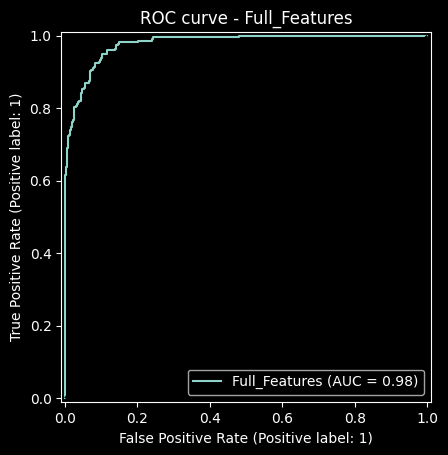

<Figure size 800x600 with 0 Axes>

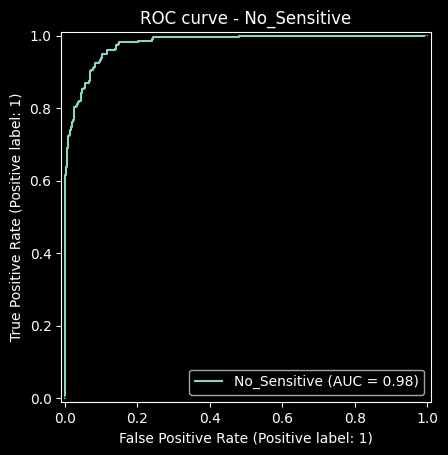

<Figure size 800x600 with 0 Axes>

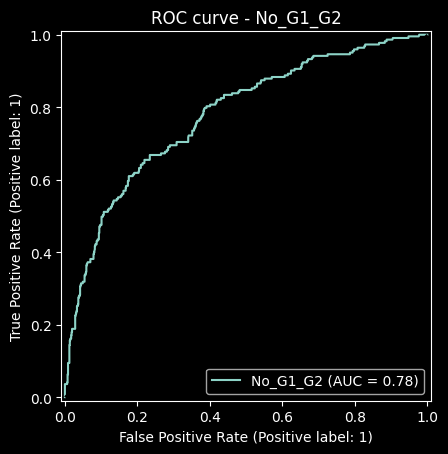

In [8]:
# Initialize context and orchestrator
import os
from core.pipeline_core.pipeline_builder import PipelineBuilder
import mlflow

# Label MLFlow experiment
if os.path.exists(".dockerenv"):
    tracking_uri = "sqlite:////app/mlflow.db"
else:
    tracking_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name="Edu_Predict_Experiments")

orchestrator = PipelineOrchestrator()
context = PipelineContext()

# Build pipeline from Notebook classes and YAML config
pipeline = PipelineBuilder.build_from_yaml("pipeline_config.yaml", orchestrator)

# Run the pipeline
try:
    final_context = orchestrator.run(context)
except Exception as e:
    logger.error(f"❌ Pipeline failed: {e}")
finally:
    print("🏁 Pipeline execution ended.")
    
    # Final report
    print("\n--- Merged datas overview ---")
    display(final_context.final_df.head())

    print("\n--- Execution stats ---")
    for step, duration in final_context.execution_time.items():
        print(f"{step:25} : {duration:.4f}s")



## Store the best run

Prepare API exporting the best model (based uppon AUC)

In [9]:
import joblib
import mlflow
import mlflow.tracking
import os

models_dir = "backend/models"
os.makedirs(models_dir, exist_ok=True)

client = mlflow.tracking.MlflowClient()
exp = client.get_experiment_by_name("Edu_Predict_Experiment")
experiment_id = exp.experiment_id if exp is not None else 0

for strategy in ["auc_score", "accuracy"]:
    label = "auc" if "auc" in strategy else "accuracy"

    # 1. Search for best run : matching compliance IAAct / RGPD
    filter_string = "tags.scenario != 'Full_Features'"

    runs = mlflow.search_runs(
        experiment_ids=[experiment_id],
        filter_string=filter_string,
        order_by=[f"metrics.{strategy} DESC"]
    )
    best_run = runs.iloc[0]
    run_id = best_run['run_id']

    algo_used = best_run.get("tags.algorithm")
    
    scenario = best_run.get("tags.mlflow.runName", "unknown")
    if not algo_used:
        algo_used = scenario.split("_")[0] if "_" in scenario else "unknown"

    logger.info(f"Best run for {label} is {run_id} with scenario {scenario} [{algo_used}]")
    

    # 2. Load and save the best model locally
    model = mlflow.sklearn.load_model(model_uri=f"runs:/{run_id}/model")
    joblib.dump(model, f"backend/models/student_model_{label}_latest.joblib")
    

    # 3. Load and save feature names

    artifacts = [a.path for a in client.list_artifacts(run_id)]
    
    try:
        if "feature_names.pkl" in artifacts:
            # New format
            local_path = client.download_artifacts(run_id, "feature_names.pkl", "backend/models/")
        else:
            # Old format
            legacy_file = [a for a in artifacts if a.startswith("feature_names_")][0]
            local_path = client.download_artifacts(run_id, legacy_file, "backend/models/")
            
        # Renommage final pour l'API
        os.rename(local_path, f"backend/models/feature_names_{label}_latest.pkl")
        
    except Exception as e:
        logger.error(f"❌ Impossible de récupérer les features pour {run_id}: {e}")

    print(f"✅ Best model and feature names based on {label} score was saved successfully : {scenario}")

2026-01-13 13:51:24.384 | INFO     | __main__:<module>:33 - Best run for auc is 2b721b2ebf45443299c4af573b32b17d with scenario LR_No_Sensitive [LR]
2026-01-13 13:51:24.417 | INFO     | __main__:<module>:33 - Best run for accuracy is d94fc8286d90462d851ebff6f944cca9 with scenario RF_No_Sensitive [RF]


✅ Best model and feature names based on auc score was saved successfully : LR_No_Sensitive
✅ Best model and feature names based on accuracy score was saved successfully : RF_No_Sensitive


# Classes and utils

Given here for example only. In order to build the whole app, all classes were re packaged out of the notebook.

## core package
- **core.file_handling_core** : business class that handle csv files
- **core.handlers** : all business classes for the Chain of Responsibilities
    - **anonymizer_handler** : Responsible of anonymization of columns in the final dataframe,
    - **compliance_audit_handler** : Util that generate a compliance report logged in MLFlow
    - **data_export_handler** : Responsible of the intermediate csv file storage
    - **data_loader** : Responsible of the initial load of the csv
    - **encoding_hanlder** : Responsible of the standardization / normalization of the datas
    - **imputation_handler** : Business classes that are responsible of the NaN handling
    - **merger_handler** : Responsible of the merge of the two dataframe : de-duplication, add some columns,
    - **[Minimizer](https://github.com/dacodemaniak/educ-predict/blob/main/core/handlers/minimizer_handler.py)** : Responsible of the reduction of numerical datas, 
    - **model_handler** : Core of the training
    - **outlier_hanlder** : business classes that process outliers using strategies,
    - **sensitive_data_handler** : Responsible of the sensitive datas exclusion
- **core.pipeline_core** : all business classes that manage the pipeline based on a yaml configuration
    - **pipeline_builder** : Responsible of the Chain building
    - **[pipeline_core](https://github.com/dacodemaniak/educ-predict/blob/main/core/pipeline_core/pipeline_core.py)** : Responsible of the pipeline orchestration, context sharing, ... 
    - **run_pipeline** : Just run the pipeline out-of-the-box
    - **[tuning](https://github.com/dacodemaniak/educ-predict/blob/main/core/pipeline_core/tuning.py)**: Run training using Optuna parameters optimization. Use *prefect* to orchestrate and update hyper parameters
- **core.strategy_core** : All concrete strategies class that handle dynamically some processes
    - **[imputation_strategy](https://github.com/dacodemaniak/educ-predict/blob/main/core/strategy_core/imputation_strategies.py)** : Responsible of the NaN handling,
    - **[outliers_strategies](https://github.com/dacodemaniak/educ-predict/blob/main/core/strategy_core/outliers_strategies.py)** : Responsible of the outliers detection and handling,
    - **[training_strategies](https://github.com/dacodemaniak/educ-predict/blob/main/core/strategy_core/training_strategies.py)** : Business classes that train using different algorithms